In [1]:
import numpy as np
import pandas as pd
import keras
import os
import glob
import math
from gensim import corpora
from nltk.corpus import stopwords # Used to remove stop words
from nltk.tokenize import word_tokenize # participle
from nltk.stem import SnowballStemmer # Extract stem
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.callbacks import ModelCheckpoint,TensorBoard, ReduceLROnPlateau,EarlyStopping
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Embedding
from keras.layers import LSTM
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras import regularizers
from keras import backend as K
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
seed = 7
np.random.seed(seed)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/minzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/minzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/minzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/minzhao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/minzhao/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# loads train data, get the feature name, data X, target Y
def load_TrainingData(path):     
    D = pd.read_csv(path, sep='\t', header=0)
    feature_names  = np.array(list(D.columns.values))
    X_train = np.array(list(D['Phrase']))
    Y_train = np.array(list(D['Sentiment']));
    return  X_train, Y_train, feature_names

# loads test data, get the feature name, data X, target Y
def load_TestingData(path): 
    D = pd.read_csv(path, sep='\t', header=0)
    X_test = np.array(list(D['Phrase']))
    X_test_PhraseID = np.array(list(D['PhraseId']))
    return  X_test,X_test_PhraseID

# shuffle the data X and target Y
def shuffle_2(X, Y):
    ids = np.arange(X.shape[0])
    np.random.shuffle(ids) 
    return X[ids], Y[ids]

## 1 Data Preview

In [3]:
# load data
X_train, Y_train, feature_names = load_TrainingData('./dataset/train/train.tsv')
X_test, X_test_PhraseID = load_TestingData('./dataset/test/test.tsv')

In [4]:
X_train

array(['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
       'A series of escapades demonstrating the adage that what is good for the goose',
       'A series', ..., 'avuncular chortles', 'avuncular', 'chortles'],
      dtype='<U283')

In [5]:
Y_train

array([1, 2, 2, ..., 3, 2, 2])

In [6]:
feature_names

array(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='<U10')

In [7]:
print ('============================== Training data shapes ==============================')
print ('X_train.shape is ', X_train.shape)
print ('Y_train.shape is ',Y_train.shape)

============================== Training data shapes ==============================
X_train.shape is  (156060,)
Y_train.shape is  (156060,)


## 2 Data Preprocessing

### 2.1 Word Tokenize

In [8]:
example = X_train[0]
example_token = nltk.word_tokenize(example)
example_token

['A',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 ',',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story',
 '.']

### 2.2 Stopwords

In [9]:
stop_words = set([])
stop_words.add('.')
stop_words.add(',')
stop_words.add(':')
stop_words.add('"')
stop_words.add(';')
stop_words.add("'")
stop_words.add('(')
stop_words.add(')')
stop_words.add('[')
stop_words.add(']')
stop_words.add('{')
stop_words.add('}')
stop_words.add('--')
stop_words.add('...')
stop_words.add('`')
stop_words.add('-')
stop_words.add('``')
stop_words.add("''")
stop_words.add("'s")
stop_words.add('us')
stop_words.add("n't")
stop_words.add('w.')
stop_words.add('-lrb-')
stop_words.add('-rrb-')
stop_words.add("'re")
print(stopwords.words('english'))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
# remove punctuation
example_without_pun = [w for w in example_token if not w in stop_words]
example_without_pun

['A',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story']

In [11]:
# remove stop word
example_without_stop = [w.lower() for w in example_without_pun if not w.lower() in stopwords.words('english')]
example_without_stop

['series',
 'escapades',
 'demonstrating',
 'adage',
 'good',
 'goose',
 'also',
 'good',
 'gander',
 'occasionally',
 'amuses',
 'none',
 'amounts',
 'much',
 'story']

### 2.3 Stemming / Lemmatisation

#### 2.3.1 Stemming

In [12]:
poter = nltk.PorterStemmer()
example_poter = [poter.stem(w) for w in example_without_stop]
example_poter

['seri',
 'escapad',
 'demonstr',
 'adag',
 'good',
 'goos',
 'also',
 'good',
 'gander',
 'occasion',
 'amus',
 'none',
 'amount',
 'much',
 'stori']

#### 2.3.2 Lemmatisation

In [13]:
def merge(words):
    new_words = []
    for word in words:
        if word:
            tag = nltk.pos_tag(word_tokenize(word)) # tag is like [('bigger', 'JJR')]
            pos = get_wordnet_pos(tag[0][1])
            if pos:
                lemmatized_word = lmtzr.lemmatize(word, pos)
                new_words.append(lemmatized_word)
            else:
                new_words.append(word)
    return new_words

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return ''

In [14]:
lmtzr = WordNetLemmatizer()
example_merge_poter = merge(example_without_stop)
example_merge_poter

['series',
 'escapade',
 'demonstrate',
 'adage',
 'good',
 'goose',
 'also',
 'good',
 'gander',
 'occasionally',
 'amuses',
 'none',
 'amount',
 'much',
 'story']

### 2.4 Processing

In [15]:
x_train_process = []
y_train_process = []
poter = nltk.PorterStemmer()
for i in range(len(X_train)):
    # tokenize
    sen_token = nltk.word_tokenize(X_train[i])
    # remove stop words
    sen_without_pun = [w for w in sen_token if not w in stop_words]
    sen_without_stop = [w.lower() for w in sen_without_pun if not w.lower() in stopwords.words('english')]
    # lemmatisation
    sen_poter = merge(sen_without_stop)
    # remove stop words again
    sen_without_stop_again = [w for w in sen_poter if not w in stopwords.words('english')]
    sen_final = [w for w in sen_without_stop_again if not w in stop_words]
    if len(sen_final) == 0:
        continue
    else:
        x_train_process.append(sen_final)
        y_train_process.append(Y_train[i])
x_train_process

[['series',
  'escapade',
  'demonstrate',
  'adage',
  'good',
  'goose',
  'also',
  'good',
  'gander',
  'occasionally',
  'amuses',
  'none',
  'amount',
  'much',
  'story'],
 ['series', 'escapade', 'demonstrate', 'adage', 'good', 'goose'],
 ['series'],
 ['series'],
 ['escapade', 'demonstrate', 'adage', 'good', 'goose'],
 ['escapade', 'demonstrate', 'adage', 'good', 'goose'],
 ['escapade'],
 ['demonstrate', 'adage', 'good', 'goose'],
 ['demonstrate', 'adage'],
 ['demonstrate'],
 ['adage'],
 ['adage'],
 ['good', 'goose'],
 ['good', 'goose'],
 ['good', 'goose'],
 ['good', 'goose'],
 ['good'],
 ['goose'],
 ['goose'],
 ['goose'],
 ['also',
  'good',
  'gander',
  'occasionally',
  'amuses',
  'none',
  'amount',
  'much',
  'story'],
 ['also',
  'good',
  'gander',
  'occasionally',
  'amuses',
  'none',
  'amount',
  'much',
  'story'],
 ['also'],
 ['also'],
 ['good',
  'gander',
  'occasionally',
  'amuses',
  'none',
  'amount',
  'much',
  'story'],
 ['gander', 'occasionally', 'a

In [16]:
x_test_process = []
poter2 = nltk.PorterStemmer()
for sen2 in X_test:
    # tokenize
    sen_token2 = nltk.word_tokenize(sen2)
    # remove stop words
    sen_without_pun2 = [w for w in sen_token2 if not w in stop_words]
    sen_without_stop2 = [w.lower() for w in sen_without_pun2 if not w.lower() in stopwords.words('english')]
    # lemmatisation
    sen_poter2 = merge(sen_without_stop2)
    # remove stop words again
    sen_without_stop_again2 = [w for w in sen_poter2 if not w in stopwords.words('english')]
    sen_final2 = [w for w in sen_without_stop_again2 if not w in stop_words]
    if len(sen_final2) == 0:
        continue
    else:
        x_test_process.append(sen_final2)
x_test_process

[['intermittently', 'please', 'mostly', 'routine', 'effort'],
 ['intermittently', 'please', 'mostly', 'routine', 'effort'],
 ['intermittently', 'please', 'mostly', 'routine', 'effort'],
 ['intermittently', 'please', 'mostly', 'routine'],
 ['intermittently', 'please'],
 ['intermittently', 'please'],
 ['intermittently'],
 ['please'],
 ['mostly', 'routine'],
 ['mostly'],
 ['routine'],
 ['effort'],
 ['kidman',
  'really',
  'thing',
  'worth',
  'watch',
  'birthday',
  'girl',
  'film',
  'stage-trained',
  'jez',
  'butterworth',
  'mojo',
  'serf',
  'yet',
  'another',
  'example',
  'sad',
  'decline',
  'british',
  'comedy',
  'post-full',
  'monty',
  'world'],
 ['kidman'],
 ['really',
  'thing',
  'worth',
  'watch',
  'birthday',
  'girl',
  'film',
  'stage-trained',
  'jez',
  'butterworth',
  'mojo',
  'serf',
  'yet',
  'another',
  'example',
  'sad',
  'decline',
  'british',
  'comedy',
  'post-full',
  'monty',
  'world'],
 ['really',
  'thing',
  'worth',
  'watch',
  'b

## 3 Build Vocabulary

In [17]:
Tokenizer = Tokenizer()
Tokenizer.fit_on_texts(np.concatenate((x_train_process, x_test_process), axis=0))

Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
print ("Vocab size",Tokenizer_vocab_size)


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Vocab size 16146


In [18]:
Tokenizer.word_index

{'film': 1,
 'movie': 2,
 'make': 3,
 'one': 4,
 'like': 5,
 'character': 6,
 'story': 7,
 'time': 8,
 'good': 9,
 'comedy': 10,
 'much': 11,
 'see': 12,
 'well': 13,
 'work': 14,
 'way': 15,
 'life': 16,
 'get': 17,
 'even': 18,
 'bad': 19,
 'go': 20,
 'little': 21,
 'performance': 22,
 'feel': 23,
 'look': 24,
 'take': 25,
 'love': 26,
 'funny': 27,
 'enough': 28,
 'director': 29,
 'new': 30,
 'give': 31,
 'come': 32,
 'thing': 33,
 'watch': 34,
 'audience': 35,
 'something': 36,
 'best': 37,
 'plot': 38,
 'people': 39,
 'end': 40,
 'two': 41,
 'never': 42,
 'act': 43,
 'interest': 44,
 'would': 45,
 'many': 46,
 'seem': 47,
 'year': 48,
 'could': 49,
 'great': 50,
 'action': 51,
 'world': 52,
 'may': 53,
 'big': 54,
 'long': 55,
 'cast': 56,
 'every': 57,
 'really': 58,
 'drama': 59,
 'actor': 60,
 'minute': 61,
 'humor': 62,
 'sense': 63,
 'another': 64,
 'picture': 65,
 'fun': 66,
 'moment': 67,
 'scene': 68,
 'first': 69,
 'without': 70,
 'screen': 71,
 'still': 72,
 'american': 

## Serialize

In [19]:
# Encode words to word index according to the vocabuilary
encoded_words_train = Tokenizer.texts_to_sequences(x_train_process)
encoded_words_test = Tokenizer.texts_to_sequences(x_test_process)

In [20]:
# Calculate the average sentence length
avg_len = list(map(len, encoded_words_train))
print(np.mean(avg_len))

3.92202842377261


<function matplotlib.pyplot.show(close=None, block=None)>

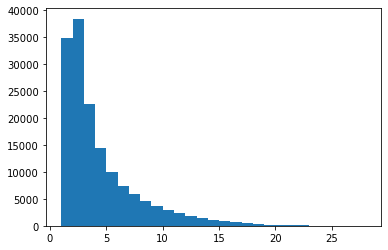

In [21]:
# Show the sentence length distribution
import matplotlib.pyplot as plt
plt.hist(avg_len, bins = range(min(avg_len), max(avg_len) + 1, 1))
plt.show

In [22]:
maxWordCount = 10
maxDictionary_size = Tokenizer_vocab_size

# split train to train and val
encoded_words_val = encoded_words_train[:32000]
encoded_words_train = encoded_words_train[32000:]
Y_Val = y_train_process[:32000]
Y_train = y_train_process[32000:]

# padding all text to same size
X_Train_encodedPadded_words = sequence.pad_sequences(encoded_words_train, maxlen=maxWordCount)
X_Val_encodedPadded_words = sequence.pad_sequences(encoded_words_val, maxlen=maxWordCount)
X_test_encodedPadded_words = sequence.pad_sequences(encoded_words_test, maxlen=maxWordCount)

## Vectorization

In [23]:
Y_train = keras.utils.to_categorical(Y_train, 5)
Y_Val   = keras.utils.to_categorical(Y_Val, 5)

## Model

In [24]:
# shuffle train data
X_Train_encodedPadded_words, Y_train = shuffle_2(X_Train_encodedPadded_words, Y_train)

In [25]:
print ('Featu are ',feature_names)
print ('============================== After extracting a validation set of 32000  ============================== ')
print ('============================== Training data shapes ==============================')
print ('X_train.shape is ', len(X_Train_encodedPadded_words))
print ('Y_train.shape is ',len(Y_train))
print ('============================== Validation data shapes ==============================')
print ('X_Val.shape is ',len(X_Val_encodedPadded_words))
print ('Y_Val.shape is ',len(Y_Val))
print ('============================== Test data shape ==============================')
print ('X_test.shape is ', len(X_test_encodedPadded_words))

Featu are  ['PhraseId' 'SentenceId' 'Phrase' 'Sentiment']
============================== After extracting a validation set of 32000  ============================== 
============================== Training data shapes ==============================
X_train.shape is  122800
Y_train.shape is  122800
============================== Validation data shapes ==============================
X_Val.shape is  32000
Y_Val.shape is  32000
============================== Test data shape ==============================
X_test.shape is  65626


In [26]:
# build model
model = Sequential()
model.add(Embedding(maxDictionary_size, 256))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

2022-03-21 18:26:28.050607: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-21 18:26:28.152505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-03-21 18:26:28.154246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:83:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-03-21 18:26:28.156024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
202

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         4133376   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

In [32]:
# set hyperparameteres
learning_rate = 0.0001
epochs = 3
batch_size = 32 
Nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004) 
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=0, verbose=1, mode='auto', cooldown=0, min_lr=1e-6)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1)

In [33]:
print ("=============================== Training =========================================")

# checkpoint
filepath = "weights-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint, reduce_lr, earlyStopping]

history  = model.fit(X_Train_encodedPadded_words, Y_train, epochs = epochs, batch_size=batch_size, verbose=1,
                    validation_data=(X_Val_encodedPadded_words, Y_Val), callbacks=callbacks_list)

=============================== Training =========================================
Epoch 1/3
3838/3838 [==============================] - 162s 42ms/step - loss: 0.6653 - accuracy: 0.7165 - val_loss: 1.0680 - val_accuracy: 0.6084 - lr: 0.0020
Epoch 2/3
3838/3838 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.7293WARNING:tensorflow:Can save best model only with val_acc available, skipping.

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.001600000075995922.
3838/3838 [==============================] - 155s 40ms/step - loss: 0.6217 - accuracy: 0.7293 - val_loss: 1.1293 - val_accuracy: 0.6098 - lr: 0.0020
Epoch 3/3
3837/3838 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.7448WARNING:tensorflow:Can save best model only with val_acc available, skipping.

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0012800000607967378.
3838/3838 [==============================] - 160s 42ms/step - loss: 0.5727 - accuracy: 0.7448 - val_

In [34]:
print ("=============================== Score =========================================")

scores = model.evaluate(X_Val_encodedPadded_words, Y_Val, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1] * 100))

=============================== Score =========================================
Accuracy: 60.83%
